# Training: Hybrid Model v1:
- Pets + Supermarket skus
- Bert Multi Model Base


In [ ]:
!pip install unidecode python-dotenv Unidecode==1.3.6 google-cloud-aiplatform transformers==4.40.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.0
    Uninstalling transformers-4.41.0:
      Successfully uninstalled transformers-4.41.0


## libs

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import requests
from collections import Counter
import re
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import time

import glob
from ast import literal_eval

import io
import math

import warnings
warnings.filterwarnings("ignore")

from numpy.linalg import norm
from matplotlib import colors

import pickle
from dotenv import load_dotenv
import json


#from password import *

from vertexai.preview.language_models import TextEmbeddingModel
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'automatch-309218-5f83b019f742.json'

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from transformers import BertTokenizer, TFBertModel
from transformers import AdamW, AdamWeightDecay, WarmUp
#import tensorflow_text as text

import warnings
warnings.filterwarnings("ignore")
#tf.debugging.set_log_device_placement(True)

## TPU

In [ ]:
##para configuracion TPU

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
#if tf.config.list_physical_devices('GPU'):
#  strategy = tf.distribute.MirroredStrategy()
#  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


## GCP Credentials

In [ ]:
project_id = 'automatch-309218'
!gcloud config set project {project_id}

!gcloud auth login
!gcloud auth application-default login

REGION = "us-central1"
BUCKET_URI = 'gs://pets-match-v2-21-12-23'

Updated property [core/project].
Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=tOv3Q3oVczG3ryj57SkYJ9zVlL1Ru6&prompt=consent&token_usage=remote&access_type=offline&code_challenge=auwXNkoLapsSNVQIqxvhw_X0oGiLeZBKTb1NxskVPOI&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AdLIrYdD1LQXQfRVqNoBA6f22dDzIzKqPIETABRuy2zjhH1eZTOniWrZbPXznm1HLTGNJw

You are now logged in as [ia@geti.cl].

## GCP Txt embedding model

In [ ]:
embedding_model_gcp = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

def get_embedding_txt_gcp(text, model=embedding_model_gcp):
    """returns the embedding for a string using gcp embedding model"""
    text = text.replace("\n", " ")
    embedding = model.get_embeddings([text])
    embedding = embedding[0].values
    return embedding

## Bert Modal & tokenizer

In [ ]:
#BERT multi

bert_multi = 'bert-base-multilingual-uncased'
#Loading tokenizer
tokenizer= BertTokenizer.from_pretrained(bert_multi)

MAX_LENGTH = 35

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
def join_products(product_1, product_2):
  join = [f'{p1} [SEP] {p2}' for p1,p2 in zip(product_1,product_2)]
  return join

## Dataset en TF Records

In [ ]:
!gsutil cp gs://pets-match-v2-21-12-23/ds_train_hybrid_10-05-24.csv .
!gsutil cp gs://pets-match-v2-21-12-23/ds_eval_hybrid_10-05-24.csv .
!gsutil cp gs://pets-match-v2-21-12-23/ds_test_hybrid_10-05-24.csv .


Copying gs://pets-match-v2-21-12-23/ds_train_hybrid_10-05-24.csv...
- [1 files][ 50.8 MiB/ 50.8 MiB]                                                
Operation completed over 1 objects/50.8 MiB.                                     
Copying gs://pets-match-v2-21-12-23/ds_eval_hybrid_10-05-24.csv...
/ [1 files][  6.3 MiB/  6.3 MiB]                                                
Operation completed over 1 objects/6.3 MiB.                                      
Copying gs://pets-match-v2-21-12-23/ds_test_hybrid_10-05-24.csv...
/ [1 files][  6.3 MiB/  6.3 MiB]                                                
Operation completed over 1 objects/6.3 MiB.                                      


In [ ]:
ds_train = pd.read_csv('ds_train_hybrid_10-05-24.csv', index_col=0)
ds_eval = pd.read_csv('ds_eval_hybrid_10-05-24.csv', index_col=0)
ds_test = pd.read_csv('ds_test_hybrid_10-05-24.csv', index_col=0)

In [ ]:
def decode_fn2(sample, max_length=MAX_LENGTH):
    features = {
        "input_ids": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
        "attention_mask": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
        #"token_type_ids": tf.io.FixedLenFeature((max_length,), dtype=tf.int64),
    }
    labels = {
        "labels": tf.io.FixedLenFeature((1,), dtype=tf.int64)
    }
    x = tf.io.parse_example(sample, features)
    y = tf.io.parse_example(sample, labels)

    return ((x),y)

def generate_tfrecords_data(chunk_ds, chunk_labels, file_name, max_length=MAX_LENGTH ):
  #chunk:
  tokenized_data = tokenizer(
      list(chunk_ds),
      padding="max_length",
      truncation=True,
      max_length=max_length,
      return_tensors="np",
  )

  labels = chunk_labels #already in numpy array

  with tf.io.TFRecordWriter(f"{file_name}.tfrecords") as file_writer:
    for i in range(len(labels)):
        features = {
            "input_ids": tf.train.Feature(
                int64_list=tf.train.Int64List(value=tokenized_data["input_ids"][i])
            ),
            "attention_mask": tf.train.Feature(
                int64_list=tf.train.Int64List(value=tokenized_data["attention_mask"][i])
            ),
            #"token_type_ids": tf.train.Feature(
            #    int64_list=tf.train.Int64List(value=tokenized_data["token_type_ids"][i])
            #),
            "labels": tf.train.Feature(
                int64_list=tf.train.Int64List(value=[labels[i]])
            ),
        }
        features = tf.train.Features(feature=features)
        example = tf.train.Example(features=features)
        record_bytes = example.SerializeToString()
        file_writer.write(record_bytes)

In [ ]:
len(ds_train), len(ds_eval), len(ds_test)

(470416, 58802, 58800)

In [ ]:
#TFRecordDataset can handle gs:// paths!

BATCH_SIZE = 64
tf_records_folder = 'tf_records_ds/hybrid_model_ds'

ds_training = tf.data.TFRecordDataset([f"{BUCKET_URI}/{tf_records_folder}/ds_train_hybrid_p1.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_train_hybrid_p2.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_train_hybrid_p3.tfrecords"])

ds_training = ds_training.map(decode_fn2)
ds_training = ds_training.batch(BATCH_SIZE, drop_remainder=True)
ds_training = ds_training.apply(
    tf.data.experimental.assert_cardinality(470416 // BATCH_SIZE) #len(y_train) = 470416 ..para no cargar el set de nuevo!
)


ds_validating = tf.data.TFRecordDataset([f"{BUCKET_URI}/{tf_records_folder}/ds_eval_hybrid_p1.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_eval_hybrid_p2.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_eval_hybrid_p3.tfrecords"])

ds_validating = ds_validating.map(decode_fn2)
ds_validating = ds_validating.batch(BATCH_SIZE, drop_remainder=True)
ds_validating = ds_validating.apply(
    tf.data.experimental.assert_cardinality(58802 // BATCH_SIZE) #len(y_valid) = 58802.
)


ds_testing = tf.data.TFRecordDataset([f"{BUCKET_URI}/{tf_records_folder}/ds_test_hybrid_p1.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_test_p2.tfrecords",
                                       f"{BUCKET_URI}/{tf_records_folder}/ds_test_p3.tfrecords"])

ds_testing = ds_testing.map(decode_fn2)
ds_testing = ds_testing.batch(BATCH_SIZE, drop_remainder=True)
#ds_testing = ds_testing.apply(
#    tf.data.experimental.assert_cardinality(58800 // BATCH_SIZE) #len(y_testing) = 58800.
#)

# Model v1- AdamW


## Training

In [ ]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
NUM_EPOCHS = 10

with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1_adamw = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = 'hybrid_model_txt_v1_adamw_loss.h5'
    filepath2 = 'hybrid_model_txt_v1_adamw_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #early_stop = EarlyStopping(monitor='val_loss', patience=15)
    train_data_size = len(ds_train)
    steps_per_epoch = int(train_data_size / BATCH_SIZE)
    num_train_steps = steps_per_epoch * NUM_EPOCHS
    warmup_steps = int(0.1 * num_train_steps)
    lr = 2e-6

    # decay schedule
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=num_train_steps,
        end_learning_rate=0.0)

    # warm-up schedule
    learning_rate_fn = WarmUp(
        initial_learning_rate=lr,
        decay_schedule_fn=linear_decay,
        warmup_steps=warmup_steps
    )

    optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=learning_rate_fn)


    #compile model
    model_txt_1_adamw.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_1_adamw.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7802908cad40> False
1 <keras.engine.input_layer.InputLayer object at 0x78028f95e170> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x780381a44130> False
3 <keras.layers.pooling.global_max_pooling1d.GlobalMaxPooling1D object at 0x7803d604c070> True
4 <keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D object at 0x78028f5210c0> True
5 <keras.layers.merging.concatenate.Concatenate object at 0x7802905ed3f0> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x78028f5ec5b0> True
7 <keras.layers.core.dense.Dense object at 0x78028f751fc0> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x78028f7dc310> True
9 <keras.layers.regularization.dropout.Dropout object at 0x78028f508dc0> True
10 <keras.layers.core.dense.Dense object at 0x78028f58cf70> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x780

In [ ]:
start = time.time()


history_1 = model_txt_1_adamw.fit(ds_training,validation_data=ds_validating, epochs=NUM_EPOCHS, callbacks=[checkpoint1, checkpoint2])

end = time.time()
total_time = end-start
print(f'time taken to train model ({NUM_EPOCHS} epochs): {total_time} secs')

Epoch 1/10


7350/7350 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.6922 - auc: 0.7705 - precision: 0.6952 - recall: 0.6843
Epoch 1: val_loss improved from inf to 0.30555, saving model to hybrid_model_txt_v1_adamw_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.87250, saving model to hybrid_model_txt_v1_adamw_acc.h5
7350/7350 [==============================] - 755s 93ms/step - loss: 0.6400 - accuracy: 0.6922 - auc: 0.7705 - precision: 0.6952 - recall: 0.6843 - val_loss: 0.3055 - val_accuracy: 0.8725 - val_auc: 0.9460 - val_precision: 0.8918 - val_recall: 0.8480
Epoch 2/10
7350/7350 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8589 - auc: 0.9271 - precision: 0.8663 - recall: 0.8487
Epoch 2: val_loss improved from 0.30555 to 0.19997, saving model to hybrid_model_txt_v1_adamw_loss.h5

Epoch 2: val_accuracy improved from 0.87250 to 0.92405, saving model to hybrid_model_txt_v1_adamw_acc.h5
7350/7350 [==============================] - 673s 92ms

In [ ]:
6892/3600

1.9144444444444444

## Evaluating

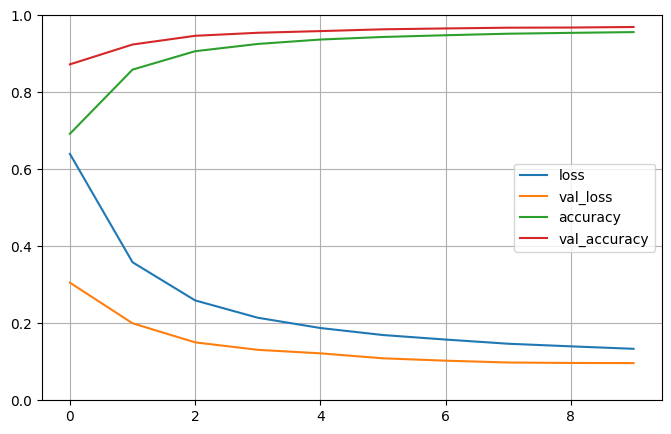

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

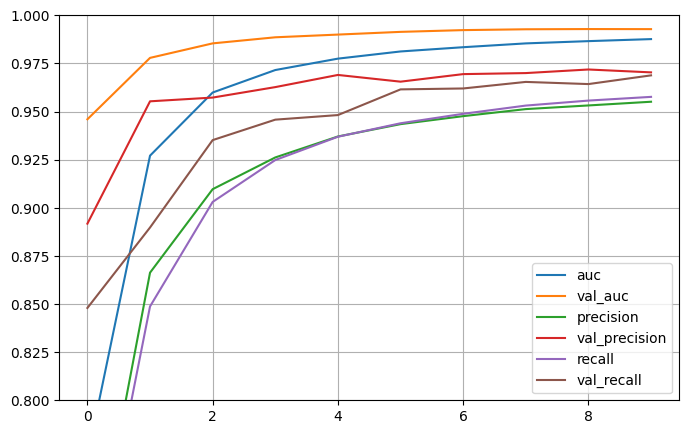

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_1_adamw.evaluate(ds_testing)

306/306 [==============================] - 17s 40ms/step - loss: 0.0941 - accuracy: 0.9693 - auc: 0.9934 - precision: 0.9710 - recall: 0.9673


[0.09411083906888962,
 0.9692606329917908,
 0.9934302568435669,
 0.9710442423820496,
 0.9672701358795166]

In [ ]:
models_folder = 'models_checkpoints'
!gsutil cp /content/hybrid_model_txt_v1_adamw_acc.h5 {BUCKET_URI}/{models_folder}
!gsutil cp /content/hybrid_model_txt_v1_adamw_loss.h5 {BUCKET_URI}/{models_folder}

Copying file:///content/hybrid_model_txt_v1_adamw_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][640.4 MiB/640.4 MiB]                                                
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/hybrid_model_txt_v1_adamw_loss.h5 [Content-

In [ ]:
20743.58/3600

5.762105555555556

# Model v1

## Training

In [ ]:
#model architecture

def model_v1(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(256, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(128, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_1 = model_v1(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = 'hybrid_model_txt_v1_loss.h5'
    filepath2 = 'hybrid_model_txt_v1_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #checkpoint3 = ModelCheckpoint(filepath3, monitor='val_recall', verbose=1, \
    #                              save_best_only=True, save_weights_only=True, \
    #                              mode='auto', save_frequency=1)

    early_stop = EarlyStopping(monitor='val_loss', patience=15)


    #initial learning rate & optimizer
    lr = 2e-6
    optimizer = tf.keras.optimizers.Adam(lr)

    #learning rate schedule --> for exploring the plateu when stuck in locals minimals
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        learning_rate=lr,
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
        mode='auto'
    )

    #compile model
    model_txt_1.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_1.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7e7c56d51d80> False
1 <keras.engine.input_layer.InputLayer object at 0x7e7c165c3fd0> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7e7da2067f10> False
3 <keras.layers.pooling.GlobalMaxPooling1D object at 0x7e7c16a90e50> True
4 <keras.layers.pooling.GlobalAveragePooling1D object at 0x7e7c16adbbe0> True
5 <keras.layers.merge.Concatenate object at 0x7e7c166ff610> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7e7c13e71450> True
7 <keras.layers.core.dense.Dense object at 0x7e7c13b64040> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7e7c16a82fe0> True
9 <keras.layers.core.dropout.Dropout object at 0x7e7c13f69420> True
10 <keras.layers.core.dense.Dense object at 0x7e7c13b67850> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7e7c13f6bf10> True
12 <keras.layers.core.dropout.Dropout object at 0x7e7c

In [ ]:
start = time.time()
epochs = 30


history_1 = model_txt_1.fit(ds_training,validation_data=ds_validating, epochs=epochs, callbacks=[reduce_lr,checkpoint1, checkpoint2, early_stop])

end = time.time()
total_time = end-start
print(f'time taken to train model ({epochs} epochs): {total_time} secs')

Epoch 1/30


7350/7350 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.7889 - auc: 0.8692 - precision: 0.7894 - recall: 0.7880
Epoch 1: val_loss improved from inf to 0.24322, saving model to hybrid_model_txt_v1_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.90734, saving model to hybrid_model_txt_v1_acc.h5
7350/7350 [==============================] - 750s 92ms/step - loss: 0.4956 - accuracy: 0.7889 - auc: 0.8692 - precision: 0.7894 - recall: 0.7880 - val_loss: 0.2432 - val_accuracy: 0.9073 - val_auc: 0.9665 - val_precision: 0.9345 - val_recall: 0.8761 - lr: 2.0000e-06
Epoch 2/30
7350/7350 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8879 - auc: 0.9468 - precision: 0.8885 - recall: 0.8870
Epoch 2: val_loss improved from 0.24322 to 0.16976, saving model to hybrid_model_txt_v1_loss.h5

Epoch 2: val_accuracy improved from 0.90734 to 0.93990, saving model to hybrid_model_txt_v1_acc.h5
7350/7350 [==============================] - 685s 93ms/step -

In [ ]:
20743.58/3600

5.762105555555556

## Evaluating

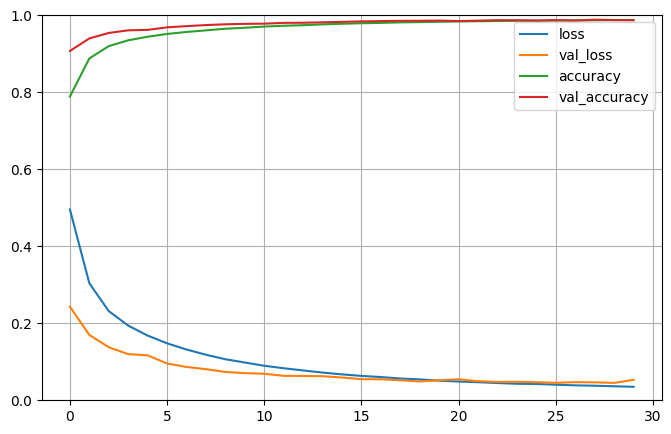

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

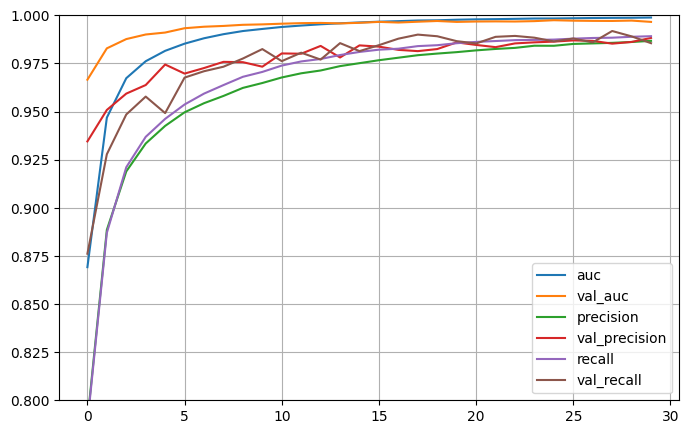

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_1.evaluate(ds_testing)

306/306 [==============================] - 14s 31ms/step - loss: 0.0589 - accuracy: 0.9865 - auc: 0.9960 - precision: 0.9876 - recall: 0.9853


[0.058868732303380966,
 0.9864685535430908,
 0.9959835410118103,
 0.9875948429107666,
 0.9852715730667114]

In [ ]:
models_folder = 'models_checkpoints'
!gsutil cp /content/hybrid_model_txt_v1_acc.h5 {BUCKET_URI}/{models_folder}
!gsutil cp /content/hybrid_model_txt_v1_loss.h5 {BUCKET_URI}/{models_folder}

Copying file:///content/hybrid_model_txt_v1_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/hybrid_model_txt_v1_loss.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which wo

## Training

In [ ]:
from transformers import TFBertForSequenceClassification

In [ ]:
with strategy.scope(): # creating the model in the TPU strategy scope

    model_txt_3 = TFBertForSequenceClassification.from_pretrained(bert_multi, num_labels=2)


    filepath1 = 'hybrid_model_txt_v3_loss.h5'
    filepath2 = 'hybrid_model_txt_v3_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #checkpoint3 = ModelCheckpoint(filepath3, monitor='val_recall', verbose=1, \
    #                              save_best_only=True, save_weights_only=True, \
    #                              mode='auto', save_frequency=1)

    early_stop = EarlyStopping(monitor='val_loss', patience=15)


    #initial learning rate & optimizer
    lr = 2e-6
    optimizer = tf.keras.optimizers.Adam(lr)

    #learning rate schedule --> for exploring the plateu when stuck in locals minimals
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        learning_rate=lr,
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
        mode='auto'
    )

    #compile model
    model_txt_3.compile(loss ='binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for index,layer in enumerate(model_txt_3.layers):

  if index < 1: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7ff3b7742b30> False
1 <keras.layers.core.dropout.Dropout object at 0x7ff3b6db81f0> True
2 <keras.layers.core.dense.Dense object at 0x7ff3b6db8820> True


In [ ]:
start = time.time()
epochs = 30


history_1 = model_txt_3.fit(ds_training,validation_data=ds_validating, epochs=epochs, callbacks=[reduce_lr,checkpoint1, checkpoint2, early_stop])

end = time.time()
total_time = end-start
print(f'time taken to train model ({epochs} epochs): {total_time} secs')

Epoch 1/30


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1000, in run_step
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1573, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/compile_utils.py", line 459, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/metrics.py", line 2347, in update_state
        return metrics_utils.update_confusion_matrix_variables(
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/metrics_utils.py", line 619, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (8, 2) and (8, 1) are incompatible


In [ ]:
20743.58/3600

5.762105555555556

## Evaluating

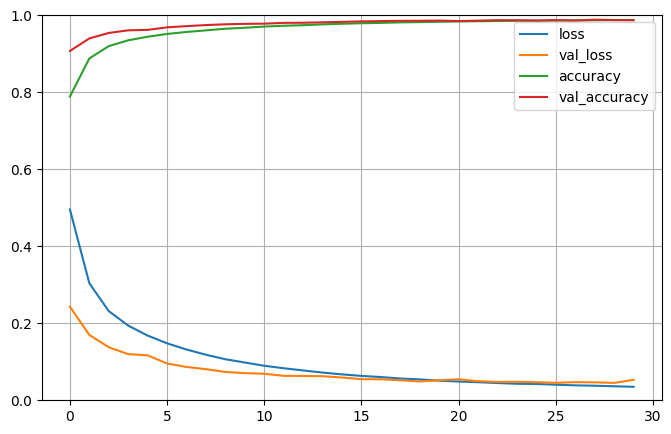

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

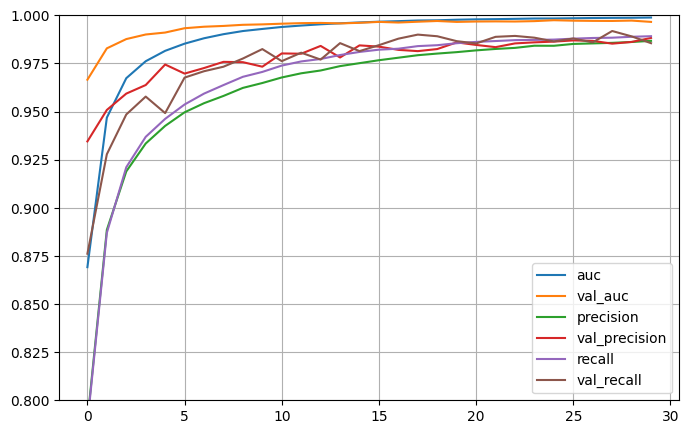

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_1.evaluate(ds_testing)

306/306 [==============================] - 14s 31ms/step - loss: 0.0589 - accuracy: 0.9865 - auc: 0.9960 - precision: 0.9876 - recall: 0.9853


[0.058868732303380966,
 0.9864685535430908,
 0.9959835410118103,
 0.9875948429107666,
 0.9852715730667114]

In [ ]:
models_folder = 'models_checkpoints'
!gsutil cp /content/hybrid_model_txt_v1_acc.h5 {BUCKET_URI}/{models_folder}
!gsutil cp /content/hybrid_model_txt_v1_loss.h5 {BUCKET_URI}/{models_folder}

Copying file:///content/hybrid_model_txt_v1_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/hybrid_model_txt_v1_loss.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which wo

# Model v2
dense_1_txt : 256 -> 128
dense_fc : 128 -> 64

## Training

In [ ]:
#model architecture

def model_v2(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(128, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.25, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.4 to 0.25

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(64, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.3, name='dropout_fc')(batch_norm_fc)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_2 = model_v2(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = 'hybrid_model_txt_v2_loss.h5'
    filepath2 = 'hybrid_model_txt_v2_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #checkpoint3 = ModelCheckpoint(filepath3, monitor='val_recall', verbose=1, \
    #                              save_best_only=True, save_weights_only=True, \
    #                              mode='auto', save_frequency=1)

    early_stop = EarlyStopping(monitor='val_loss', patience=15)


    #initial learning rate & optimizer
    lr = 2e-6
    optimizer = tf.keras.optimizers.Adam(lr)

    #learning rate schedule --> for exploring the plateu when stuck in locals minimals
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        learning_rate=lr,
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
        mode='auto'
    )

    #compile model
    model_txt_2.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_2.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7c073f3eb7c0> False
1 <keras.engine.input_layer.InputLayer object at 0x7c073f552e60> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7c07803a7c10> False
3 <keras.layers.pooling.GlobalMaxPooling1D object at 0x7c073f273b50> True
4 <keras.layers.pooling.GlobalAveragePooling1D object at 0x7c073f5f15a0> True
5 <keras.layers.merge.Concatenate object at 0x7c073f3e9db0> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c073f2d2fb0> True
7 <keras.layers.core.dense.Dense object at 0x7c073a45ba60> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c073a458d60> True
9 <keras.layers.core.dropout.Dropout object at 0x7c073a413a60> True
10 <keras.layers.core.dense.Dense object at 0x7c073ae86050> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7c073f18ed70> True
12 <keras.layers.core.dropout.Dropout object at 0x7c07

In [ ]:
start = time.time()
epochs = 15


history_1 = model_txt_2.fit(ds_training,validation_data=ds_validating, epochs=epochs, callbacks=[reduce_lr,checkpoint1, checkpoint2, early_stop])

end = time.time()
total_time = end-start
print(f'time taken to train model ({epochs} epochs): {total_time} secs')

Epoch 1/15


7350/7350 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.8054 - auc: 0.8839 - precision: 0.8101 - recall: 0.7977
Epoch 1: val_loss improved from inf to 0.24723, saving model to hybrid_model_txt_v2_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.90598, saving model to hybrid_model_txt_v2_acc.h5
7350/7350 [==============================] - 740s 91ms/step - loss: 0.4580 - accuracy: 0.8054 - auc: 0.8839 - precision: 0.8101 - recall: 0.7977 - val_loss: 0.2472 - val_accuracy: 0.9060 - val_auc: 0.9697 - val_precision: 0.9515 - val_recall: 0.8555 - lr: 2.0000e-06
Epoch 2/15
7350/7350 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8988 - auc: 0.9544 - precision: 0.9007 - recall: 0.8964
Epoch 2: val_loss improved from 0.24723 to 0.16324, saving model to hybrid_model_txt_v2_loss.h5

Epoch 2: val_accuracy improved from 0.90598 to 0.94187, saving model to hybrid_model_txt_v2_acc.h5
7350/7350 [==============================] - 668s 91ms/step -

In [ ]:
10303/3600

2.8619444444444446

## Evaluating

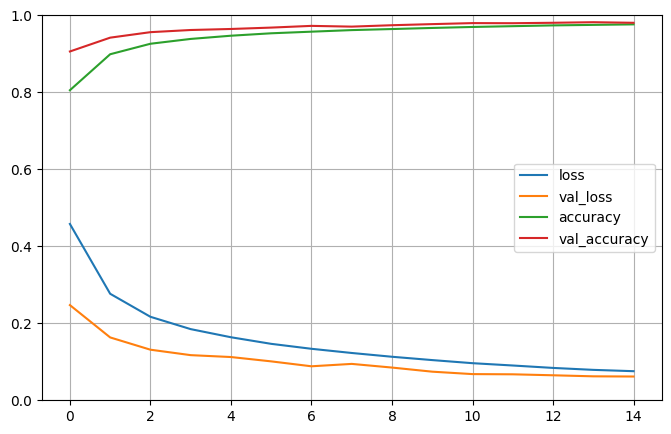

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

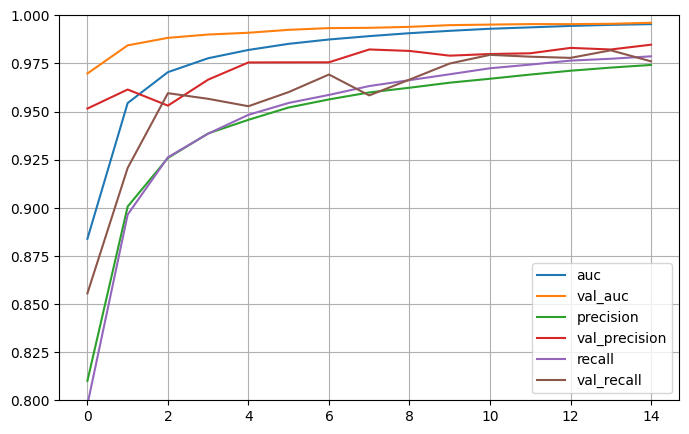

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_2.evaluate(ds_testing)

306/306 [==============================] - 16s 43ms/step - loss: 0.0635 - accuracy: 0.9800 - auc: 0.9960 - precision: 0.9834 - recall: 0.9764


[0.06354787200689316,
 0.9799836874008179,
 0.9960137009620667,
 0.9834140539169312,
 0.9763731360435486]

In [ ]:
models_folder = 'models_checkpoints'
!gsutil cp /content/hybrid_model_txt_v2_acc.h5 {BUCKET_URI}/{models_folder}
!gsutil cp /content/hybrid_model_txt_v2_loss.h5 {BUCKET_URI}/{models_folder}

Copying file:///content/hybrid_model_txt_v2_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][639.5 MiB/639.5 MiB]                                                
Operation completed over 1 objects/639.5 MiB.                                    
Copying file:///content/hybrid_model_txt_v2_loss.h5 [Content-Type=applica

# Model v3
- dense layer1 : +64 neurons
- dense fc: +64 neurons
- dropout1 : 0.3
- dropout2 : 0.5

## Training

In [ ]:
#model architecture

def model_v3(model, seq_length=MAX_LENGTH):

    input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int64, name="attention_mask")

    embedding_layer = model(input_ids=input_ids, attention_mask=attention_mask)[0]

    max_pool_txt = tf.keras.layers.GlobalMaxPool1D(name = 'max_pooling_txt')(embedding_layer)
    avg_pool_txt = tf.keras.layers.GlobalAveragePooling1D(name = 'avg_pooling_txt')(embedding_layer)
    concat_txt = tf.keras.layers.concatenate([max_pool_txt, avg_pool_txt])

    batch_norm_1_txt = tf.keras.layers.BatchNormalization(name='batch_norm1_txt')(concat_txt)
    dense_1_txt = tf.keras.layers.Dense(320, activation='relu', name='dense_1_txt')(batch_norm_1_txt)
    batch_norm_2_txt = tf.keras.layers.BatchNormalization(name='batch_norm2_txt')(dense_1_txt)
    dropout_1_txt = tf.keras.layers.Dropout(0.3, name='dropout_1_txt')(batch_norm_2_txt) #changed from 0.25 to 0.3

    #fully connected layer
    dense_fc = tf.keras.layers.Dense(192, activation='relu', name='dense_fc')(dropout_1_txt)
    batch_norm_fc = tf.keras.layers.BatchNormalization(name='batch_norm_fc')(dense_fc)
    dropout_fc = tf.keras.layers.Dropout(0.5, name='dropout_fc')(batch_norm_fc) #from 0.3 to 0.5

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels')(dropout_fc) #sigmoid instead of softmax, classes=1 :{0..1}

    classif_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return classif_model

In [ ]:
with strategy.scope(): # creating the model in the TPU strategy scope
    bert_multi_model = TFBertModel.from_pretrained(bert_multi)
    model_txt_3 = model_v3(bert_multi_model, seq_length=MAX_LENGTH)

    filepath1 = 'hybrid_model_txt_v3_loss.h5'
    filepath2 = 'hybrid_model_txt_v3_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #checkpoint3 = ModelCheckpoint(filepath3, monitor='val_recall', verbose=1, \
    #                              save_best_only=True, save_weights_only=True, \
    #                              mode='auto', save_frequency=1)

    early_stop = EarlyStopping(monitor='val_loss', patience=15)


    #initial learning rate & optimizer
    lr = 2e-6
    optimizer = tf.keras.optimizers.Adam(lr)

    #learning rate schedule --> for exploring the plateu when stuck in locals minimals
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        learning_rate=lr,
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
        mode='auto'
    )

    #compile model
    model_txt_3.compile(loss = 'binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
for index,layer in enumerate(model_txt_3.layers):

  if index < 3: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7ff3b54cfbb0> False
1 <keras.engine.input_layer.InputLayer object at 0x7ff3b6a5ded0> False
2 <transformers.models.bert.modeling_tf_bert.TFBertModel object at 0x7ff3b514f070> False
3 <keras.layers.pooling.GlobalMaxPooling1D object at 0x7ff3b7765c00> True
4 <keras.layers.pooling.GlobalAveragePooling1D object at 0x7ff3b514ce20> True
5 <keras.layers.merge.Concatenate object at 0x7ff3b6a5e710> True
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff50087dc00> True
7 <keras.layers.core.dense.Dense object at 0x7ff5008a5de0> True
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff3b5b45ed0> True
9 <keras.layers.core.dropout.Dropout object at 0x7ff3b5e651b0> True
10 <keras.layers.core.dense.Dense object at 0x7ff3b6a46800> True
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff3b67d8d00> True
12 <keras.layers.core.dropout.Dropout object at 0x7ff3

In [ ]:
start = time.time()
epochs = 30


history_1 = model_txt_3.fit(ds_training,validation_data=ds_validating, epochs=epochs, callbacks=[reduce_lr,checkpoint1, checkpoint2, early_stop])

end = time.time()
total_time = end-start
print(f'time taken to train model ({epochs} epochs): {total_time} secs')

Epoch 1/30


7350/7350 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7702 - auc_1: 0.8500 - precision_1: 0.7734 - recall_1: 0.7644
Epoch 1: val_loss improved from inf to 0.28336, saving model to hybrid_model_txt_v3_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.88896, saving model to hybrid_model_txt_v3_acc.h5
7350/7350 [==============================] - 770s 96ms/step - loss: 0.5618 - accuracy: 0.7702 - auc_1: 0.8500 - precision_1: 0.7734 - recall_1: 0.7644 - val_loss: 0.2834 - val_accuracy: 0.8890 - val_auc_1: 0.9596 - val_precision_1: 0.9348 - val_recall_1: 0.8363 - lr: 2.0000e-06
Epoch 2/30
7350/7350 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.8677 - auc_1: 0.9336 - precision_1: 0.8717 - recall_1: 0.8622
Epoch 2: val_loss improved from 0.28336 to 0.19456, saving model to hybrid_model_txt_v3_loss.h5

Epoch 2: val_accuracy improved from 0.88896 to 0.93440, saving model to hybrid_model_txt_v3_acc.h5
7350/7350 [==========================

In [ ]:
21420/3600

5.95

## Evaluating

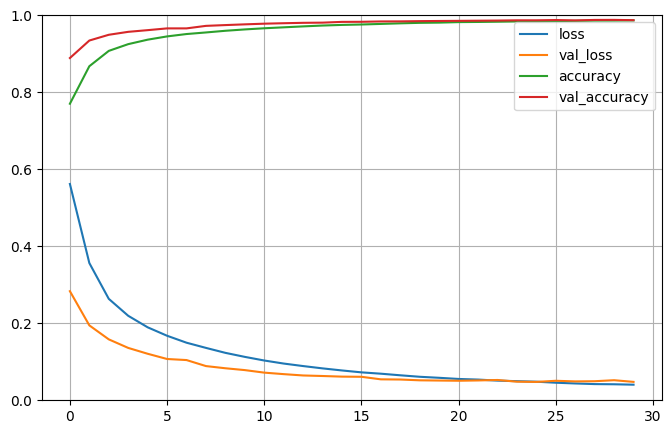

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
#pd.DataFrame(history_1.history)

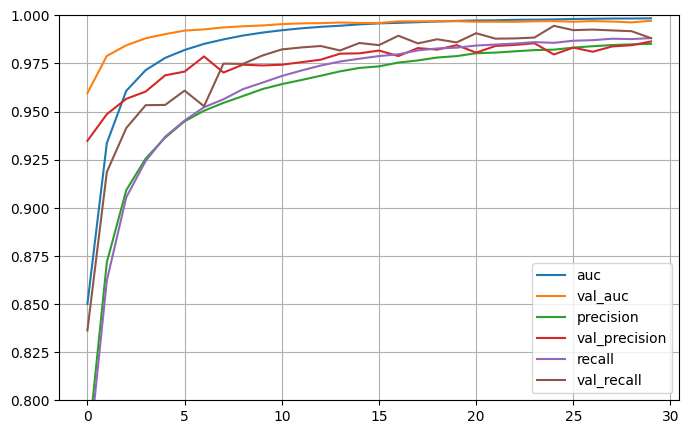

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc_1']
precision_recall['val_auc'] = history_1.history['val_auc_1']
precision_recall['precision'] = history_1.history['precision_1']
precision_recall['val_precision'] = history_1.history['val_precision_1']
precision_recall['recall'] = history_1.history['recall_1']
precision_recall['val_recall'] = history_1.history['val_recall_1']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_3.evaluate(ds_testing)

306/306 [==============================] - 13s 33ms/step - loss: 0.0507 - accuracy: 0.9877 - auc_1: 0.9968 - precision_1: 0.9858 - recall_1: 0.9896


[0.050666484981775284,
 0.9876940250396729,
 0.9967901110649109,
 0.9858366250991821,
 0.9895673394203186]

In [ ]:
models_folder = 'models_checkpoints'
!gsutil cp /content/hybrid_model_txt_v3_acc.h5 {BUCKET_URI}/{models_folder}
!gsutil cp /content/hybrid_model_txt_v3_loss.h5 {BUCKET_URI}/{models_folder}

Copying file:///content/hybrid_model_txt_v3_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][640.8 MiB/640.8 MiB]                                                
Operation completed over 1 objects/640.8 MiB.                                    
Copying file:///content/hybrid_model_txt_v3_loss.h5 [Content-Type=applica

## Training

In [ ]:
from transformers import TFBertForSequenceClassification

In [ ]:
with strategy.scope(): # creating the model in the TPU strategy scope

    model_txt_3 = TFBertForSequenceClassification.from_pretrained(bert_multi, num_labels=2)


    filepath1 = 'hybrid_model_txt_v3_loss.h5'
    filepath2 = 'hybrid_model_txt_v3_acc.h5'

    #chekpoints
    checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, \
                                  save_best_only=True, save_weights_only=True, \
                                  mode='auto', save_frequency=1)

    #checkpoint3 = ModelCheckpoint(filepath3, monitor='val_recall', verbose=1, \
    #                              save_best_only=True, save_weights_only=True, \
    #                              mode='auto', save_frequency=1)

    early_stop = EarlyStopping(monitor='val_loss', patience=15)


    #initial learning rate & optimizer
    lr = 2e-6
    optimizer = tf.keras.optimizers.Adam(lr)

    #learning rate schedule --> for exploring the plateu when stuck in locals minimals
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        learning_rate=lr,
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=1e-4,
        mode='auto'
    )

    #compile model
    model_txt_3.compile(loss ='binary_crossentropy', optimizer= optimizer ,
                        metrics=["accuracy",
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for index,layer in enumerate(model_txt_3.layers):

  if index < 1: #freeze bert layer (dont want to tune the bert weights)
    layer.trainable = False


  print(index, layer, layer.trainable)

0 <transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7ff3b7742b30> False
1 <keras.layers.core.dropout.Dropout object at 0x7ff3b6db81f0> True
2 <keras.layers.core.dense.Dense object at 0x7ff3b6db8820> True


In [ ]:
start = time.time()
epochs = 30


history_1 = model_txt_3.fit(ds_training,validation_data=ds_validating, epochs=epochs, callbacks=[reduce_lr,checkpoint1, checkpoint2, early_stop])

end = time.time()
total_time = end-start
print(f'time taken to train model ({epochs} epochs): {total_time} secs')

Epoch 1/30


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1000, in run_step
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1573, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/compile_utils.py", line 459, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/metrics.py", line 2347, in update_state
        return metrics_utils.update_confusion_matrix_variables(
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/metrics_utils.py", line 619, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (8, 2) and (8, 1) are incompatible


In [ ]:
20743.58/3600

5.762105555555556

## Evaluating

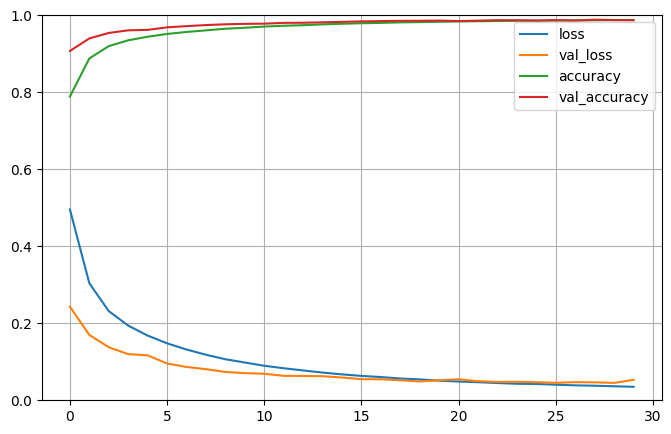

In [ ]:
loss_and_acc = {}
loss_and_acc['loss'] = history_1.history['loss']
loss_and_acc['val_loss'] = history_1.history['val_loss']
loss_and_acc['accuracy'] = history_1.history['accuracy']
loss_and_acc['val_accuracy'] = history_1.history['val_accuracy']

df_metrics_1 = pd.DataFrame(loss_and_acc)
df_metrics_1.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

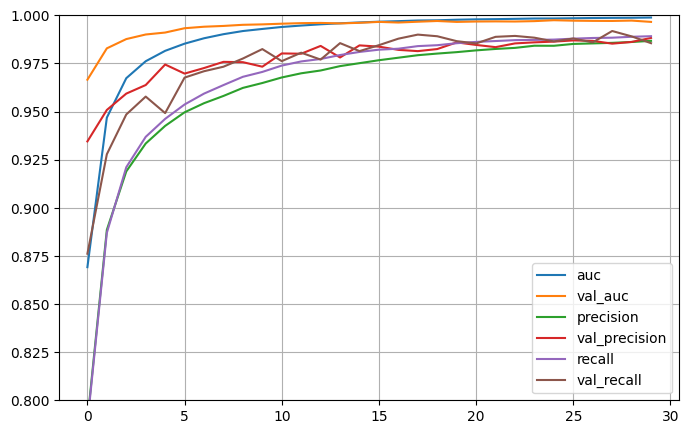

In [ ]:
precision_recall = {}
precision_recall['auc'] = history_1.history['auc']
precision_recall['val_auc'] = history_1.history['val_auc']
precision_recall['precision'] = history_1.history['precision']
precision_recall['val_precision'] = history_1.history['val_precision']
precision_recall['recall'] = history_1.history['recall']
precision_recall['val_recall'] = history_1.history['val_recall']

df_metrics_2 = pd.DataFrame(precision_recall)
df_metrics_2.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.8,1)
plt.show()

In [ ]:
#evaluate
model_txt_1.evaluate(ds_testing)

306/306 [==============================] - 14s 31ms/step - loss: 0.0589 - accuracy: 0.9865 - auc: 0.9960 - precision: 0.9876 - recall: 0.9853


[0.058868732303380966,
 0.9864685535430908,
 0.9959835410118103,
 0.9875948429107666,
 0.9852715730667114]

In [ ]:
models_folder = 'models_checkpoints'
!gsutil cp /content/hybrid_model_txt_v1_acc.h5 {BUCKET_URI}/{models_folder}
!gsutil cp /content/hybrid_model_txt_v1_loss.h5 {BUCKET_URI}/{models_folder}

Copying file:///content/hybrid_model_txt_v1_acc.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/640.4 MiB.                                    
Copying file:///content/hybrid_model_txt_v1_loss.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which wo